# Import and Data

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from preprocess import *

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_mode = 'train'

In [2]:
tickers = '5871.TW' # '5871.TW'
start = '1999-01-01'
C = yf.Ticker(tickers)

# get and clean data
prc = fetch_price(C, start)
prc = pct_change(prc)
prc = clean(prc)

In [3]:
# Train data
df = prc.copy()
df = A(df, rolling = 5)
df = K(df)
df = reaname_col(df)
df = talib_func(df)

rm_col =  ['open', 'high', 'low', 'close', 'volume', 'Dividends', 'Stock Splits', 'o-c-nextday']
cols = df.columns.tolist()
train_cols = [x for x in cols if x not in rm_col]
len(train_cols)

# Train test
df.dropna(inplace=True)
df_t_v, df_test = df.loc[:"2023"], df.loc["2024":]
df_train, df_valid = df_t_v[:int(len(df_t_v)*0.9)], df_t_v[int(len(df_t_v)*0.9):]
max(df_valid.index), min(df_test.index)

(Timestamp('2023-12-29 00:00:00+0800', tz='Asia/Taipei'),
 Timestamp('2024-01-02 00:00:00+0800', tz='Asia/Taipei'))

In [4]:
# Ordernal data
x_train, x_valid = categorized(df_train[train_cols], df_valid[train_cols], 20)
_, x_test = categorized(df_t_v[train_cols], df_test[train_cols], 20)
"""
scaler = StandardScaler()
df_train = scaling(df_train)
df_test = scaling(df_test)
"""
x_train.index = df_train.index
y_train = df_train['o-c-nextday']
x_valid.index = df_valid.index
y_valid = df_valid['o-c-nextday']
x_test.index = df_test.index
y_test = df_test['o-c-nextday']
(y_train.index != x_train.index).sum()

0

In [5]:
# Loader
if data_mode == 'train':
        """
        # To define state it is hard to define with using past window data method, 
        # so use indicators replacing the window datas
        window_size = 1
        x, y, date = window_x_y(df_train, window_size)
        X = process_x(x)
        """
        # inidicators
        train_loader, valid_loader, test_loader = \
                loader(np.array(x_train), np.array(y_train), batch_size=50), \
                loader(np.array(x_valid), np.array(y_valid), batch_size=50), \
                loader(np.array(x_test), np.array(y_test), batch_size=50)


        # dataloader_test = loader(x_test, y_test, 50)

# RL - Q Learning and DQN

## Q learning
- Data preprocess: ordinal for state, [ref](https://medium.com/@nyxqianl/stock-trader-with-q-learning-91e70161762b)
- Q learning [method](https://www.csie.ntu.edu.tw/~lyuu/theses/thesis_r96922117.pdf)

### 1. Random agent 

In [6]:
def agent(state):
    pass
def cum_rewards(list_, r):
    return [np.sum([list_[j]*(r**(j-i)) for j in range(i, len(list_))]) for i, s in enumerate(list_)]

In [7]:
# Action [sell, buy]
actions_space = [0, 1]
# For cum rewards
gamma = .8

states = []
actions = []
rewards = []
position = 0
return_the_buy = 0
for _, (state, y) in enumerate(zip(np.array(x_train), np.array(y_train))):
    y_ = y.copy()
    
    action = agent(state)    
    ########
    # What agent do 
    random_num = np.random.rand(2)
    prob = random_num / random_num.sum()
    action = np.random.choice(actions_space, p=prob)
    ########
    # If open:
    if action == 1:            
        if position == 0:
            # print('Open position')
            """
            1. return the buy: total return for the period between buy and sell
            2. position: 1 for have stock, 0 for no stock
            3. period: the period between buy and sell
            4. states_: the states between buy and sell
            5. actions_: the actions between buy and sell
            """           
            return_the_buy, position, period = y_, 1, 1
            states_, actions_ = [], []
            states_.append(state)
            actions_.append(action)
        else:
            period += 1
            return_the_buy += y_
            states_.append(state)
            actions_.append(action)
    
    # If close 
    elif position == 1:
        return_the_buy -= .004
        rewards_ = [return_the_buy for i in range(period)]
        position = 0
        '''
        # Check if len of states_, actions_, rewards_ are the same
        print(len(states_), len(actions_), len(rewards_))
        '''
        # Add returns to whole trajectory
        if len(states_) == len(actions_) == len(rewards_):
            # print('Close position')
            rewards_ = cum_rewards(rewards_, gamma)
            states.extend(states_)
            actions.extend(actions_)
            rewards.extend(rewards_)
        # Add state, action, reward of time t
        states.append(state)
        actions.append(action)
        rewards.append(0.)
        
    # If no buy and no position
    elif position == 0:
        states.append(state)
        actions.append(action)
        rewards.append(0.)

"""
len(states), len(actions), len(rewards) might not be the same with len(y_train)
if the last actions is buy with no close
"""
print(len(states), len(actions), len(rewards), len(y_train))

2604 2604 2604 2608


In [8]:
y_train.sum()

0.12066128795583053

In [9]:
print(f"Return | " \
    f"Buy and hold: {y_train[:len(actions)].sum():.5f} | " \
    f"Random actor: {np.dot(y_train[:len(actions)].T, np.array(actions)).item():.5f}")

Return | Buy and hold: 0.14693 | Random actor: -0.09378


### 2. Q learning

問題：可以用連續的資料做RL嗎？state基本不太會重複，怎麼更新。

In [10]:
states = torch.flatten(torch.tensor(np.array(x_train)), 1)
states_valid = torch.flatten(torch.tensor(np.array(x_valid)), 1)

##### Group to States: Use KMean / Plot

要先把每個variable分成ordinal資料再作kmean不然分不太出來，會幾乎都變成同種類別

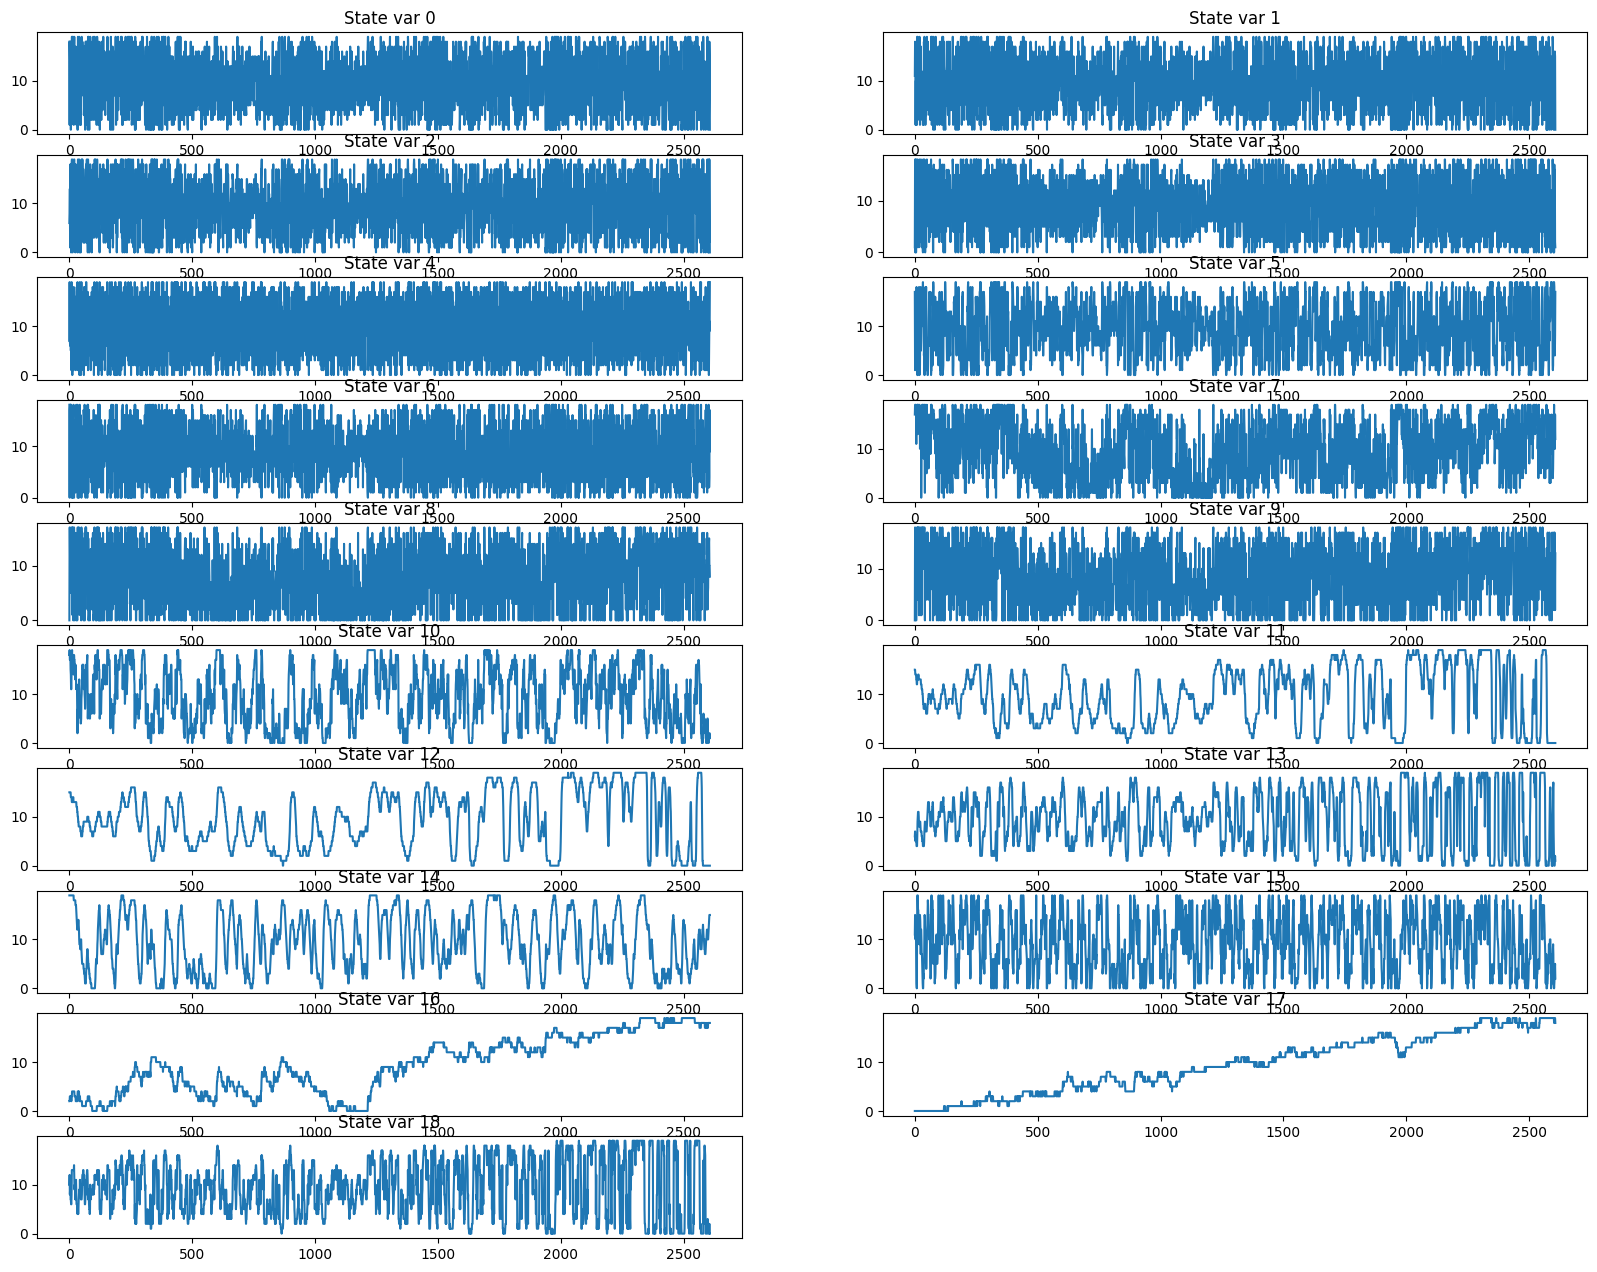

In [11]:
plt.figure(figsize=(20, 30))
for i in range(states.shape[1]):
    plt.subplot(states.shape[1], 2, i + 1)
    plt.title(f"State var {i}")
    plt.plot(states[:, i])
# plt.plot(states[:, 3])

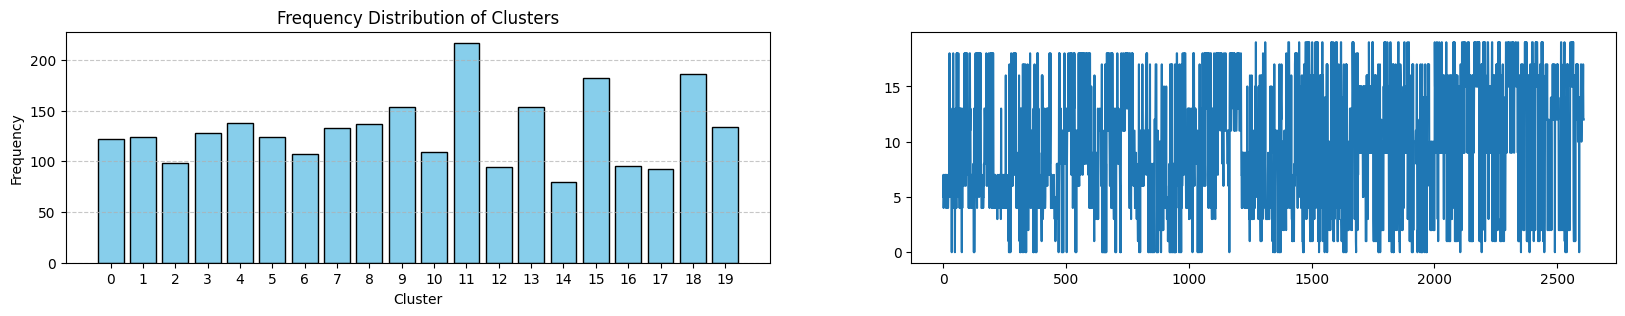

In [12]:
num_state = 20
kmeans = KMeans(n_clusters=num_state)
kmeans.fit(states)
states_labels = kmeans.labels_ # .predict(states)
states_labels_valid = kmeans.predict(states_valid)
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.hist(states_labels, bins=np.arange(0, len(np.unique(states_labels)) + 1) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.xticks(np.arange(len(np.unique(states_labels))))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Clusters')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.subplot(1, 2, 2)
plt.plot(states_labels)

##### Model

問題
1. Action 不會影響 States，要怎麼修改演算法
2. 如果要加維持0倉的選擇要怎麼做

In [63]:
#############
# Set params and init. Update Q 
alpha = .1 # learning rate
gamma = .9 # discount rate
episode = 1000
position = 0
#############

# Define action
""" 說明
all_action_space = ['hold', 'long', 'short', 'clear']
    0. None:不做任何事
    1. Hold:維持目前留倉口數，不建立新倉，也不平倉。
    2. Long1:買進stock。
    3. Short1:賣出stock。
    4. Clear:將留倉部位全部平倉。 
all_position = [0, 1, -1]
action_space = ['none', 'long', 'short']
"""
action_space = [1, -1]


# Init values for each state, action
print(np.unique(states_labels))
print(len(np.unique(states_labels)) == num_state)
values = np.ones((num_state, len(action_space)))

# def reward
def get_reward(action, y, position):
    reward = y * action
    if action != position:
        position = action
    return reward, position

def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Subtracting max(z) for numerical stability
    return exp_z / np.sum(exp_z)

total_values = []
rewards_valid_hist = []
best_valid_reward = -100
for i in range(episode):
    # Train 
    for step, y in enumerate(y_train):
        if step == len(states_labels) - 1:
            break 
        
        # Get data need to update Q
        state_now = states_labels[step]
        state_future = states_labels[step + 1]
        action = np.random.choice(action_space, size=1, p=softmax(values[state_now])).item()
        reward, position = get_reward(action, y, position)
        
        # Update Q value
        if action == -1:
            action_value_col = 0
        elif action == 1:
            action_value_col = 1
        values[state_now, action_value_col] = \
            values[state_now, action_value_col] + \
            alpha * (reward  + gamma * max(values[state_future]) - values[state_now, action]) #
            
    total_values.append(np.sum(values, axis = 0))
    
    # Valid
    rewards_valid = 0
    position = 0
    for step, y in enumerate(y_valid):
        if step == len(states_labels_valid) - 1:
            break         
        # Get data need to update Q
        state_now = states_labels_valid[step]
        action = action_space[np.argmax(values[state_now])]
        reward, position = get_reward(action, y, position)
        rewards_valid += reward
    rewards_valid_hist.append(rewards_valid)
    if rewards_valid > best_valid_reward:
        best_valid_reward = rewards_valid
        best_values = values
    
    
    

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
True


Text(0, 0.5, 'Reward')

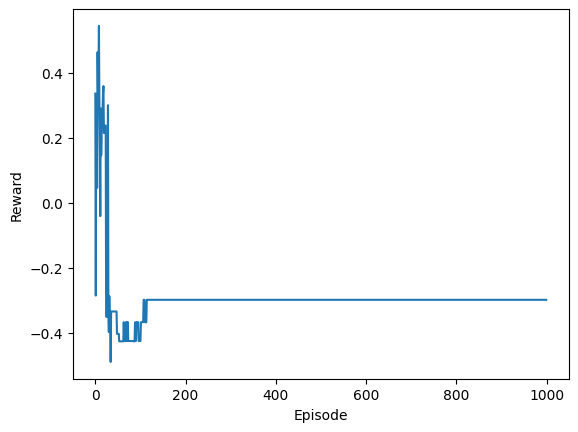

In [62]:
# Valid return
plt.plot(rewards_valid_hist)
plt.xlabel('Episode')
plt.ylabel('Reward')

array([[0.54957925, 0.5563627 ],
       [0.57688679, 0.57066049],
       [0.54184083, 0.58947893],
       [0.56217306, 0.55178317],
       [0.55951875, 0.53390877],
       [0.55872576, 0.54535831],
       [0.54336121, 0.55329909],
       [0.55649791, 0.53609776],
       [0.52409723, 0.53565642],
       [0.5255622 , 0.5313863 ],
       [0.54337995, 0.57982026],
       [0.53225281, 0.49900905],
       [0.59549955, 0.62071219],
       [0.48970876, 0.5078686 ],
       [0.60892881, 0.62188277],
       [0.57717786, 0.52226231],
       [0.58687674, 0.57242786],
       [0.59849707, 0.59243351],
       [0.46649749, 0.49599771],
       [0.49921261, 0.55001111]])

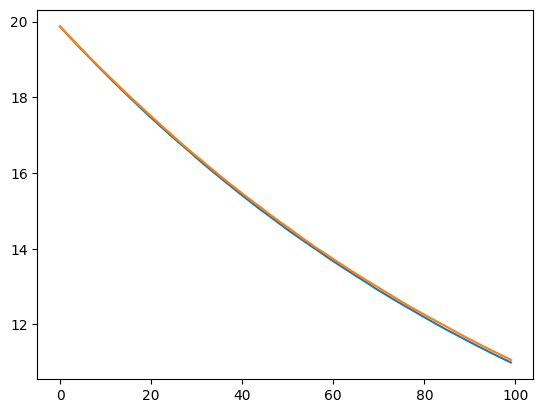

In [43]:
# Check train update
plt.plot(np.array(total_values))
values

In [1]:
import torch
torch.nan

nan

TypeError: _sum() got an unexpected keyword argument 'axix'

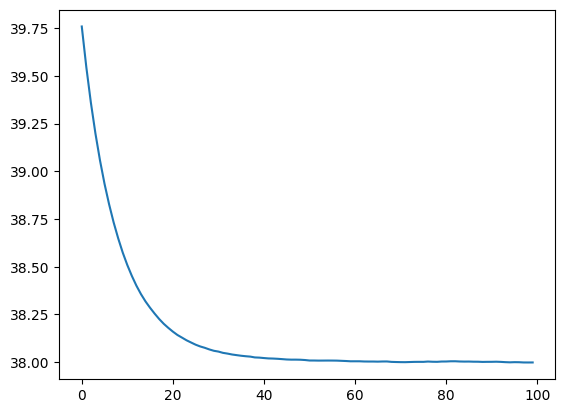

In [21]:
plt.plot(total_values)
values.sum(axix = 1)

##### Test

1. Sort state with "train data KMean"
2. Select action based on values
3. Backtest

### DQN

找論文！！！

In [14]:
from torch.optim.lr_scheduler import StepLR
from torch.distributions import Categorical
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class FcNetwork(nn.Module):

    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, state):
        state = torch.flatten(state, 1)
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(hid)
        return F.softmax(self.fc3(hid), dim=-1)
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(5, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.softmax(x, dim=-1) # torch.tanh(x)

In [15]:
class DQNAgent():
    
    def __init__(self, network, observe_network):
        self.network = network
        self.observe_network = observe_network
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.000005)
        
    def forward(self, state):
        return self.network(state)
    
    def learn(self, state, reward, beta = .001):
        """
        state and reward for 1 episode
        """
        # Train network
        self.network.train()
        p_train = self.network(state)
        # Max prob 
        probs_train = torch.max(p_train, dim=1)[0]
        # action to [-1, 0, 1] if actions number = 3
        action = torch.argmax(p_train, dim=1)
        if p_train.shape[1] == 3:
            action -= 1
        # Observe network
        p_observe = self.observe_network(state)
        probs_observe = torch.max(p_observe, dim=1)[0]
        # KL div
        kl = F.kl_div(p_train, p_observe, reduction='batchmean')
        # PPO rewards
        reward *= probs_observe/probs_train
        reward = reward - beta * kl
        loss = (-torch.log(probs_train) * reward).sum() # You don't need to revise this to pass simple baseline (but you can)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item(), action
    
    def learn_observe(self,):
        pass
    
    def sample(self, dataloader_train):
        states, rewards, actions, returns, log_probs_observes = [], [], [], [], []
        # x is state
        for x, y in tqdm(dataloader_train):
            # print(episode)
            # for each batch look as a "trajectory", or "episode"
            # return action, log_prob in a episode
            p = self.observe_network(x)
            p = p.detach()
            action = torch.argmax(p, dim=1) 
            if p.shape[1] == 3:
                action -= 1
            log_prob = torch.log(torch.max(p, dim=1)[0])
            reward = torch.mul(y.reshape(-1), action.to(dtype = torch.float32))
            states.append(x)
            returns.append(y)
            actions.append(action)
            rewards.append(reward)
            log_probs_observes.append(log_prob)
        return states, rewards, actions, returns, log_probs_observes
    
    def validate(self, state):
        with torch.no_grad():
            self.network.eval()
            p = self.network(state)
            action = torch.argmax(p, dim=1) 
            if p.shape[1] == 3:
                action -= 1
        return action

In [16]:
""""""""""""""""""""""""
### settings ###
# Models
model_names = ['resnet', 'fcnet']
model_name = model_names[0]
# Create agents
num_classes = 2
# Method
method = "DQN"
# Set
epoch = 1000
beta = .00001
""""""""""""""""""""""""
# Short 
if num_classes == 2:
    short = ""
elif num_classes == 3:  
    short = "_short"
# Input size
for x, y in dataloader_train:
    input_size = torch.flatten(x, 1).shape[1]
# Define model
if model_name == 'resnet':
    network_collect_data = ResNet(BasicBlock, [3, 4, 6, 3], num_classes).to(device)
    network_learn = ResNet(BasicBlock, [3, 4, 6, 3], num_classes).to(device)
elif model_name == 'fcnet':
    network_collect_data = PolicyGradientNetwork(input_size, num_classes).to(device)
    network_learn = PolicyGradientNetwork(input_size, num_classes).to(device)
agent = PolicyGradientAgent(network_learn, network_collect_data)
new_directory = f"result/{method}/{model_name}"
if not os.path.exists(new_directory):
    os.makedirs(new_directory)
    
# Collect data (experience)
"""
For states, rewards, and actions:
[states_for_episodes_1, states_for_episodes_2, ...]
[rewards_for_episodes_1, rewards_for_episodes_2, ...]
[actions_for_episodes_1, actions_for_episodes_2, ...]
"""
states, rewards, actions, returns, log_probs_observes = agent.sample(dataloader_train)
print(f'Total {len(states)} episodes')

# train
import pickle
returns_train = []
returns_val = []
min_val_loss = 1000000
for i in range(epoch):
    loss_train_epoch = 0
    rewards_train_epoch = 0
    adj_fact_pos, adj_fact_neg = 1, 1
    for episode, (state, action, reward, return_) in enumerate(zip(states, actions, rewards, returns)):
        """
        reward: reward from experience of another network
        return_: real close - open, as real rewards, not rewards after actions
        print(len(state), len(action), len(reward), len(return_))
        """
        # Adjust rewards
        reward = torch.where(reward > 0, reward * adj_fact_pos, reward)
        reward = torch.where(reward < 0, reward * adj_fact_neg, reward)
        
        # learn
        loss, action_train = agent.learn(state, reward, beta)       
        loss_train_epoch += loss
        
        # print(action_train)
        action_pos_ratio = torch.sum(action_train > 0)/len(action_train)
        action_neg_ratio = torch.sum(action_train < 0)/len(action_train)
        '''
        print('action=1 ratio:', action1_ratio)
        if action_pos_ratio < 0.2:
            adj_fact_pos *= 1.05
        elif action_pos_ratio > 0.7:
            adj_fact_pos *= 0.9
        
        if action_neg_ratio < 0.2:   bv
            adj_fact_neg *= 1.05
        elif action_neg_ratio > 0.7:
            adj_fact_neg *= 0.9
        '''
        
        # compute returns
        reward_train = torch.mul(return_.reshape(-1), action_train.to(dtype = torch.float32))
        rewards_train_epoch += reward_train.sum()
        
    returns_train.append(rewards_train_epoch.detach().cpu()/len(dataloader_train))
    # print(actions)
    
    rewards_val_epoch = 0
    for x, y in dataloader_valid:
        action_val = agent.validate(x)
        reward_val = torch.mul(y.reshape(-1), action_val.to(dtype = torch.float32))
        rewards_val_epoch += reward_val.sum()
    returns_val.append(rewards_val_epoch.detach().cpu()/len(dataloader_valid))
    
    print(f'epoch: {i} ========')
    print('action pos ratio:', action_pos_ratio)
    print('action neg ratio:', action_neg_ratio)
    print(f'train loss/rewards: {loss, rewards_train_epoch.item()/len(dataloader_train)}')
    print(f'val rewards: {rewards_val_epoch/len(dataloader_valid)}')
    
    if rewards_val_epoch.detach().cpu() < min_val_loss:
        min_val_loss = rewards_val_epoch.detach().cpu()
        torch.save(agent.network, f'result/{method}/{model_name}/best_agent{short}.pt')
    if i % 100 == 0:
        torch.save(agent.network, f'result/{method}/{model_name}/agent_checkpoint_{i}{short}.pt')
        
    with open(f'result/{method}/{model_name}/returns_train_val{short}.pkl', 'wb') as f:
        pickle.dump((returns_train, returns_val), f)
        

NameError: name 'dataloader_train' is not defined

In [ ]:
action_val, torch.cat(returns).sum()

(tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
         1, 0, 0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0'),
 tensor(-0.1633, device='cuda:0'))

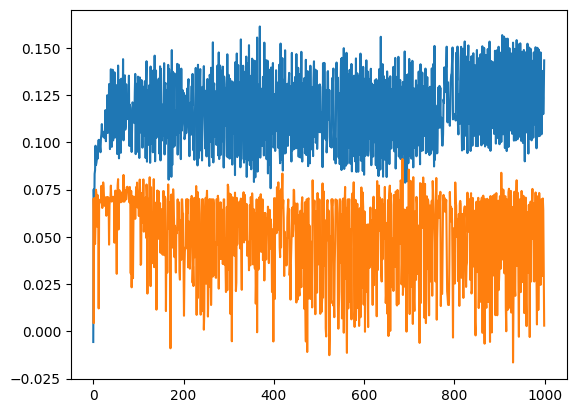

In [ ]:

plt.plot(returns_train)
plt.plot(returns_val)

In [ ]:
agent.network.train()  # Switch network into training mode 
EPISODE_PER_BATCH = 1  # update the  agent every 5 episode
NUM_BATCH = 500        # totally update the agent for 400 time

avg_total_rewards, avg_final_rewards = [], []

for episode, (x, y) in enumerate(dataloader_train):
    action, log_prob = agent.sample(state) # at, log(at|st)
    reward, done, _ = env.step(action)
    
prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode, (x, y) in enumerate(dataloader_train):
        
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at, log(at|st)
            reward, done, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward) # change here
            # ! IMPORTANT !
            # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
            #                                                         rewards :     r1, r2 ,r3 ......
            # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
            #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement Actor-Critic
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                
                break

    print(f"rewards looks like ", np.shape(rewards))  
    #print(f"log_probs looks like ", np.shape(log_probs))     
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

  0%|          | 0/48 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)